In [ ]:
from google.colab import drive
drive.mount('/content/drive')


KeyboardInterrupt: 

In [ ]:
!pip install opencv-python-headless


In [ ]:
# import the necessary packages
from skimage.segmentation import clear_border #Clear objects connected to the label image border.
from imutils import contours #define/read close images
import numpy as np
import argparse #recommended command-line parsing module in the Python standard library.
import imutils #Python basic image processing functional package to do image translation, rotation, resizing, skeletonization, or blur amount detection.
import cv2 #open cv is used for image processing/visualization

In [ ]:

def extract_digits_and_symbols(image, charCnts, minW=5, minH=15):
	# grab the internal Python iterator for the list of character
	# contours, then  initialize the character ROI and location
	# lists, respectively
	charIter = charCnts.__iter__()
	rois = []
	locs = []

	# keep looping over the character contours until we reach the end
	# of the list
	while True:
		try:
			# grab the next character contour from the list, compute
			# its bounding box, and initialize the ROI
			c = next(charIter)
			(cX, cY, cW, cH) = cv2.boundingRect(c)
			roi = None

			# check to see if the width and height are sufficiently
			# large, indicating that we have found a digit
			if cW >= minW and cH >= minH:
				# extract the ROI
				roi = image[cY:cY + cH, cX:cX + cW]
				rois.append(roi)
				locs.append((cX, cY, cX + cW, cY + cH))

			# otherwise, we are examining one of the special symbols
			else:
				# MICR symbols include three separate parts, so we
				# need to grab the next two parts from our iterator,
				# followed by initializing the bounding box
				# coordinates for the symbol
				parts = [c, next(charIter), next(charIter)]
				(sXA, sYA, sXB, sYB) = (np.inf, np.inf, -np.inf,
					-np.inf)

				# loop over the parts
				for p in parts:
					# compute the bounding box for the part, then
					# update our bookkeeping variables
					(pX, pY, pW, pH) = cv2.boundingRect(p)
					sXA = min(sXA, pX)
					sYA = min(sYA, pY)
					sXB = max(sXB, pX + pW)
					sYB = max(sYB, pY + pH)

				# extract the ROI
				roi = image[sYA:sYB, sXA:sXB]
				rois.append(roi)
				locs.append((sXA, sYA, sXB, sYB))

		# we have reached the end of the iterator; gracefully break
		# from the loop
		except StopIteration:
			break

	# return a tuple of the ROIs and locations
	return (rois, locs)


In [ ]:
# initialize the list of reference character names, in the same
# order as they appear in the reference image where the digits
# their names and:
# T = Transit (delimit bank branch routing transit #)
# U = On-us (delimit customer account number)
# A = Amount (delimit transaction amount)
# D = Dash (delimit parts of numbers, such as routing or account)
charNames = ["1", "2", "3", "4", "5", "6", "7", "8", "9", "0",
	"T", "U", "A", "D"]


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:

# Image = Image.open('/content/drive/MyDrive/ChequeDetection/bearer-cheque.jpg')
# load the reference MICR image from disk, convert it to grayscale,
# and threshold it, such that the digits appear as *white* on a
# *black* background
ref = cv2.imread('/content/drive/MyDrive/micr_e13b_reference1.png')
ref = cv2.cvtColor(ref, cv2.COLOR_BGR2GRAY)
ref = imutils.resize(ref, width=400)
ref = cv2.threshold(ref, 0, 255, cv2.THRESH_BINARY_INV |
	cv2.THRESH_OTSU)[1]


In [ ]:
# Find contours in the MICR image
refCnts, _ = cv2.findContours(ref.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Sort contours from left to right
refCnts = sorted(refCnts, key=lambda c: cv2.boundingRect(c)[0])

# Create a clone of the original image to draw contours on
clone = np.dstack([ref.copy()] * 3)

# Loop over the sorted contours
for c in refCnts:
    # Compute the bounding box of the contour
    x, y, w, h = cv2.boundingRect(c)

    # Draw a green bounding box around the contour on the clone image
    cv2.rectangle(clone, (x, y), (x + w, y + h), (0, 255, 0), 2)


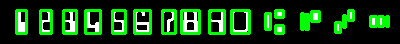

In [ ]:

# show the output of applying the simple contour method
from google.colab.patches import cv2_imshow
cv2_imshow(clone)


In [ ]:

# extract the digits and symbols from the list of contours, then
# initialize a dictionary to map the character name to the ROI
(refROIs, refLocs) = extract_digits_and_symbols(ref, refCnts,
	minW=10, minH=20)
chars = {}

# re-initialize the clone image so we can draw on it again
clone = np.dstack([ref.copy()] * 3)

In [ ]:

for i in refROIs:
  cv2_imshow(i)

In [ ]:

for i in refLocs:
  print(i)


(16, 10, 26, 33)
(40, 10, 51, 33)
(63, 10, 76, 33)
(85, 10, 100, 33)
(112, 10, 125, 33)
(134, 10, 150, 33)
(162, 10, 175, 33)
(181, 10, 199, 33)
(209, 10, 224, 33)
(231, 10, 249, 33)
(265, 10, 283, 33)
(301, 11, 319, 29)
(335, 10, 353, 32)
(370, 16, 388, 26)


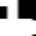

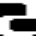

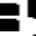

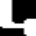

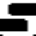

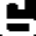

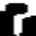

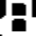

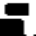

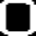

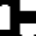

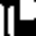

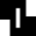

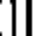

In [ ]:

# loop over the reference ROIs and locations
for (name, roi, loc) in zip(charNames, refROIs, refLocs):
	# draw a bounding box surrounding the character on the output
	# image
	(xA, yA, xB, yB) = loc
	cv2.rectangle(clone, (xA, yA), (xB, yB), (0, 255, 0), 2)

	# resize the ROI to a fixed size, then update the characters
	# dictionary, mapping the character name to the ROI
	roi = cv2.resize(roi, (36, 36))
	chars[name] = roi

	# display the character ROI to our screen
	cv2_imshow(roi)
	# cv2.waitKey(0)

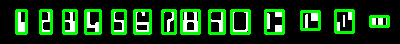

In [ ]:

# show the output of our better method
cv2_imshow(clone)

In [ ]:
chars

{'1': array([[255, 255, 255, ...,   0,   0,   0],
        [255, 255, 255, ...,   0,   0,   0],
        [255, 255, 255, ...,   0,   0,   0],
        ...,
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 144, 117, 117],
        [255, 255, 255, ...,  49,   0,   0]], dtype=uint8),
 '2': array([[255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        [230, 230, 230, ..., 255, 255, 255],
        ...,
        [255, 255, 255, ..., 255, 255, 255],
        [117, 117, 153, ..., 153, 117, 117],
        [  0,   0,  67, ...,  67,   0,   0]], dtype=uint8),
 '3': array([[255, 255, 255, ...,   0,   0,   0],
        [255, 255, 255, ...,   0,   0,   0],
        [230, 230, 230, ...,   0,   0,   0],
        ...,
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 172, 122, 117],
        [255, 255, 255, ..., 103,  10,   0]], dtype=uint8),
 '4': array([[255, 255, 255, ...,   0,   0,   0],
        [255, 255, 255, ...,   0,   0,   

In [ ]:

# initialize a rectangular kernel (wider than it is tall) along with
# an empty list to store the output of the check OCR
rectKernel = cv2.getStructuringElement(cv2.MORPH_RECT, (17, 7))
output = []
# load the input image, grab its dimensions, and apply array slicing
# to keep only the bottom 20% of the image (that's where the account
# information is)
fileNames = ['/content/drive/MyDrive/Banck-Cheque-OCR-and-MICR-Detection/sbi_cts.png','/content/drive/MyDrive/Banck-Cheque-OCR-and-MICR-Detection/X_138.jpeg','/content/drive/MyDrive/Banck-Cheque-OCR-and-MICR-Detection/X_076.jpeg','/content/drive/MyDrive/Banck-Cheque-OCR-and-MICR-Detection/X_053.jpeg','/content/drive/MyDrive/Banck-Cheque-OCR-and-MICR-Detection/X_083.jpeg','/content/drive/MyDrive/Banck-Cheque-OCR-and-MICR-Detection/X_099.jpeg']
# image = cv2.imread("/content/drive/MyDrive/ChequeDetection/sbi_cts.jpeg")
# image = cv2.imread("/content/drive/MyDrive/ChequeDetection/bearer-cheque.jpg")
#image = cv2.imread("/content/drive/MyDrive/ChequeDetection/X_138.jpeg")
#image = cv2.imread("/content/drive/MyDrive/ChequeDetection/X_006.jpeg")
#image = cv2.imread("/content/drive/MyDrive/ChequeDetection/X_010.jpeg")
#image = cv2.imread("/content/drive/MyDrive/ChequeDetection/X_053.jpeg")
inputFile = fileNames[5] # 7 cheques 0,1,2,3,4,5,6
image = cv2.imread(inputFile)
(h, w,) = image.shape[:2]
delta = int(h - (h * 0.2))
bottom = image[delta:h, 0:w]

In [ ]:
cv2_imshow(image)


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
cv2_imshow(bottom)

In [ ]:

# convert the bottom image to grayscale, then apply a blackhat
# morphological operator to find dark regions against a light
# background (i.e., the routing and account numbers)
gray = cv2.cvtColor(bottom, cv2.COLOR_BGR2GRAY)
blackhat = cv2.morphologyEx(gray, cv2.MORPH_BLACKHAT, rectKernel)

In [ ]:
cv2_imshow(blackhat)

In [ ]:

# compute the Scharr gradient of the blackhat image, then scale
# the rest back into the range [0, 255]
gradX = cv2.Sobel(blackhat, ddepth=cv2.CV_32F, dx=1, dy=0,
	ksize=7)
gradX = np.absolute(gradX)
(minVal, maxVal) = (np.min(gradX), np.max(gradX))
gradX = (255 * ((gradX - minVal) / (maxVal - minVal)))
gradX = gradX.astype("uint8")

In [ ]:

cv2_imshow(gradX)

In [ ]:

# apply a closing operation using the rectangular kernel to help
# cloes gaps in between rounting and account digits, then apply
# Otsu's thresholding method to binarize the image
gradX = cv2.morphologyEx(gradX, cv2.MORPH_CLOSE, rectKernel)
gradX = cv2.morphologyEx(gradX, cv2.MORPH_CLOSE, rectKernel)
thresh = cv2.threshold(gradX, 0, 255,
cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]


In [ ]:
cv2_imshow(thresh)

In [ ]:

# remove any pixels that are touching the borders of the image (this
# simply helps us in the next step when we prune contours)
thresh = clear_border(thresh)

In [ ]:

cv2_imshow(thresh)

In [ ]:

# find contours in the thresholded image, then initialize the
# list of group locations
groupCnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL,
	cv2.CHAIN_APPROX_SIMPLE)
groupCnts = imutils.grab_contours(groupCnts)
groupLocs = []
# loop over the group contours
for (i, c) in enumerate(groupCnts):
	# compute the bounding box of the contour
	(x, y, w, h) = cv2.boundingRect(c)
	# only accept the contour region as a grouping of characters if
	# the ROI is sufficiently large
	if w > 5 and h > 5:
		groupLocs.append((x, y, w, h))
# sort the digit locations from left-to-right
groupLocs = sorted(groupLocs, key=lambda x:x[0])

In [ ]:
# loop over the group locations
for (gX, gY, gW, gH) in groupLocs:
    # initialize the group output of characters
    groupOutput = []
    # extract the group ROI of characters from the grayscale
    # image, then apply thresholding to segment the digits from
    # the background of the credit card
    group = gray[gY - 15:gY + gH + 15, gX - 15:gX + gW + 15]
    _, group = cv2.threshold(group, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)

    # find character contours in the group, then sort them from
    # left to right
    charCnts = cv2.findContours(group.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    charCnts = imutils.grab_contours(charCnts)
    charCnts = sorted(charCnts, key=lambda c: cv2.boundingRect(c)[0])

    # find the characters and symbols in the group
    (rois, locs) = extract_digits_and_symbols(group, charCnts)

    # loop over the ROIs from the group
    for roi in rois:
        # initialize the list of template matching scores and
        # resize the ROI to a fixed size
        scores = []
        roi = cv2.resize(roi, (36, 36))

        # loop over the reference character name and corresponding
        # ROI
        for charName in charNames:
            # apply correlation-based template matching, take the
            # score, and update the scores list
            result = cv2.matchTemplate(roi, chars[charName], cv2.TM_CCOEFF)
            (_, score, _, _) = cv2.minMaxLoc(result)
            scores.append(score)

        # the classification for the character ROI will be the
        # reference character name with the *largest* template
        # matching score
        groupOutput.append(charNames[np.argmax(scores)])

    # draw (padded) bounding box surrounding the group along with
    # the OCR output of the group
    cv2.rectangle(image, (gX - 10, gY + delta - 10), (gX + gW + 10, gY + gH + delta), (0, 0, 255), 2)
    cv2.putText(image, "".join(groupOutput), (gX - 10, gY + delta - 25), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 255), 1)

    # add the group output to the overall check OCR output
    output.append("".join(groupOutput))


In [ ]:
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

In [ ]:

output = ''.join(output)
chequeNum = ''
idx = output[1:].find(output[0])

chequeNum = output[:8]
micrCode = output[8:]
print(chequeNum)
print(micrCode)

U309089U
5002110123426160U31


In [ ]:
!pip install pillow
!pip install pytesseract
!sudo apt install tesseract-ocr
!sudo apt install libtesseract-dev

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 38 not upgraded.
Need to get 4,816 kB of archives.
After this operation, 15.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-eng all 1:4.00~git30-7274cfa-1.1 [1,591 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-osd all 1:4.00~git30-7274cfa-1.1 [2,990 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr amd64 4.1.1-2.1build1 [236 kB]
Fetched 4,816 kB in 0s (18.7 MB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debco

In [ ]:

# import the necessary packages
from PIL import Image
import pytesseract
import argparse
import cv2
import os

In [ ]:

!ls -alrt /usr/bin/tesseract

In [ ]:

# load the example image and convert it to grayscale
# image = cv2.imread("/content/drive/MyDrive/ChequeDetection/sbi_cts.jpeg")
#image = cv2.imread("/content/drive/MyDrive/ChequeDetection/X_138.jpeg")
#image = cv2.imread("/content/drive/MyDrive/ChequeDetection/X_006.jpeg")
#image = cv2.imread("/content/drive/MyDrive/ChequeDetection/X_010.jpeg")
#image = cv2.imread("/content/drive/MyDrive/ChequeDetection/X_053.jpeg")
image = cv2.imread(inputFile)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
# check to see if we should apply thresholding to preprocess the
# image
bgSettings = "blur" # "thresh" or "blur"
if bgSettings == "thresh":
	gray = cv2.threshold(gray, 0, 255,
		cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
# make a check to see if median blurring should be done to remove
# noise
elif bgSettings == "blur":
	gray = cv2.medianBlur(gray, 3)
# write the grayscale image to disk as a temporary file so we can
# apply OCR to it
filename = "{}.png".format(os.getpid())
cv2.imwrite(filename, gray)

In [ ]:

filename

In [ ]:

!ls

In [ ]:

Image.open(filename)

In [ ]:

# load the image as a PIL/Pillow image, apply OCR, and then delete
# the temporary file
from google.colab.patches import cv2_imshow
# cv2_imshow(clone)
text = pytesseract.image_to_string(Image.open(filename), lang="eng")
os.remove(filename)
print(text)
# show the output images
cv2_imshow(image)
cv2_imshow(gray)

In [ ]:

lines = text.split('\n')
lines


In [ ]:
accountNum = ''
ifscCode = ''
sappmNum = ''
import re

# Regular expression pattern to match IFSC code
ifsc_regexp = re.compile('IFS')

# Regular expression pattern to match SAPPM number
sappm_regexp = re.compile('SAPPM')

# Extract account number, IFSC code, and SAPPM number from the lines
for line in lines[:-4]:
    num = re.findall(r'\d+', line)
    num = ''.join(num)
    if len(num) > 12:
        accountNum = num
        break

for line in lines:
    # Search for IFSC code
    if ifsc_regexp.search(line):
        segments = line.split(' ')
        code = re.findall(r'\d+', line)
        regexp1 = re.compile(code[0])
        for seg in segments:
            if regexp1.search(seg):
                ifscCode = seg
                break
        break

# Search for SAPPM number
for line in lines:
    if sappm_regexp.search(line):
        segments = line.split(' ')
        sappmNum = segments[-1]  # Assuming SAPPM number is the last segment
        break

print("IFSC Code:", ifscCode)
print("Account Number:", accountNum)
print("SAPPM Number:", sappmNum)


In [ ]:
def is_sappm_present_in_micr(sappm_number, micr_number):
    # Check if the SAPPM number is present within the MICR number
    if sappm_number in micr_number:
        return True
    else:
        return False

# Example usage
sappm_number = '426160'  # Replace this with the MICR number
micr_number = '5002110123426160U31'     # Replace this with the SAPPM number to check
if is_sappm_present_in_micr(sappm_number, micr_number):
    print("Valid MICR number")
else:
    print("Invalid MICR number")


In [ ]:

import os

# The list of column names as mentioned in the CSV file
headersCSV = ['CHEQUE-NUMBER','MICR-CODE','IFSC-CODE','ACCOUNT-NUMBER','SAPPM-NO']

if( not os.path.isfile('/content/drive/MyDrive/chequeData.csv')):
  import csv

  # open the file in the write mode
  f = open('/content/drive/MyDrive/chequeData.csv', 'w')

  # create the csv writer
  writer = csv.writer(f)

  # write a row to the csv file
  writer.writerow(headersCSV)

  # close the file
  f.close()


In [ ]:

# Pre-requisite - Import the DictWriter class from csv  module
from csv import DictWriter

# The list of column names as mentioned in the CSV file
headersCSV = ['CHEQUE-NUMBER','MICR-CODE','IFSC-CODE','ACCOUNT-NUMBER','SAPPM_NO']
# The data assigned to the dictionary
dict={'CHEQUE-NUMBER':chequeNum,'MICR-CODE':micrCode,'IFSC-CODE':ifscCode,'ACCOUNT-NUMBER':accountNum,'SAPPM_NO':sappmNum}

# Pre-requisite - The CSV file should be manually closed before running this code.

# First, open the old CSV file in append mode, hence mentioned as 'a'
# Then, for the CSV file, create a file object
with open('/content/drive/MyDrive/chequeData.csv', 'a', newline='') as f_object:
    # Pass the CSV  file object to the Dictwriter() function
    # Result - a DictWriter object
    dictwriter_object = DictWriter(f_object, fieldnames=headersCSV)
    # Pass the data in the dictionary as an argument into the writerow() function
    dictwriter_object.writerow(dict)
    # Close the file object
    f_object.close()


In [ ]:
import pandas as pd
data= pd.read_csv("/content/drive/MyDrive/chequeData.csv")
data

In [ ]:
import pandas as pd

# Read the CSV file
data = pd.read_csv("/content/drive/MyDrive/chequeData.csv")

# Convert the data to JSON format
json_data = data.to_json(orient="records")

# Save the JSON data to a file
with open("/content/drive/MyDrive/chequeData.json", "w") as json_file:
    json_file.write(json_data)


Below cell no need -- just a trial

In [ ]:
import cv2

def whitespace_reduction(image_path):
    # Load the image
    image = cv2.imread(image_path)

    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Thresholding to obtain binary image
    _, binary = cv2.threshold(gray, 200, 255, cv2.THRESH_BINARY)

    # Find contours
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Check if contours are found
    if not contours:
        print("No contours found.")
        return None

    # Get the bounding box of the contours
    x_values = [c[:, 0, 0] for c in contours]
    y_values = [c[:, 0, 1] for c in contours]
    min_x, min_y = min(min(x_values)), min(min(y_values))
    max_x, max_y = max(max(x_values)), max(max(y_values))

    # Crop the image using the bounding box coordinates
    cropped_image = image[min_y:max_y, min_x:max_x]

    return cropped_image

# Example usage
image_path = '/content/drive/MyDrive/Banck-Cheque-OCR-and-MICR-Detection/X_053.jpeg'
cropped_image = whitespace_reduction(image_path)
if cropped_image is not None:
    cv2.imwrite('/content/drive/MyDrive/Banck-Cheque-OCR-and-MICR-Detection/cropped_image.jpg', cropped_image)
